# Austrian energy system Tutorial Part 3: A Policy Scenario

**Pre-requisites**
- You have the *MESSAGEix* framework installed and working
- You have run Austrian energy system baseline scenario (``austria.ipynb``) and solved it successfully

**Introduction**

In this notebook, we will step through creating and investigating a policy scenario.

We will look into the effect of wind generation subsidies on the electricity sector. These subsidies will take the form of capital investment subsidies, effectively reducing the costs of capital investment.

# Setup and Helper Variables

In [20]:
# load required packages 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import ixmp as ix
import message_ix

In [21]:
# launch the IX modeling platform using the local default database
mp = ix.Platform(name="default", jvmargs="-Duser.language=en")

In [23]:
country = 'Turkey'

plants = [
    "coal_ppl", 
    "gas_ppl", 
    "oil_ppl", 
    "bio_ppl", 
    "hydro_ppl",
    "wind_ppl", 
    "solar_pv_ppl", # actually primary -> final
    "geothermal",
]

lights = [
    "low_efficiency", 
    "high_efficiency", 
]

# Create the New Policy Scenario Datastructure

This operation is done by cloning the baseline scenario, which will then be edited.

In [24]:
scen_df = mp.scenario_list() # to find the name of the wanted scenario, simply print scen_df
scen_df.loc[scen_df["scenario"] == "baseline"] # to show just the scenario we are interested in

,model,scenario,scheme,is_default,is_locked,cre_user,cre_date,upd_user,upd_date,lock_user,lock_date,annotation,version
0,Austrian energy model,baseline,MESSAGE,1,0,ggungor,2025-01-19 21:43:22.629000,ggungor,2025-01-19 21:49:53.068000,None,None,initial commit for Austria model,3
6,Turkey energy model,baseline,MESSAGE,1,0,ggungor,2025-03-02 20:04:33.854000,ggungor,2025-04-06 12:18:10.967000,None,None,initial commit for Turkey model,6
12,Westeros Electrified,baseline,MESSAGE,1,0,ggungor,2025-01-05 14:15:57.407000,ggungor,2025-01-05 14:16:19.441000,None,None,basic model of Westeros electrification,1


In [25]:
model = "Turkey energy model"
scen = "baseline"
mp.open_db() # only open if you're on a local database!
base = message_ix.Scenario(mp, model, scen)
scenario = base.clone(model, 'wind subsidies', 'testing wind subsidies', keep_solution=False)
scenario.check_out()

In [26]:
mp.scenario_list()

,model,scenario,scheme,is_default,is_locked,cre_user,cre_date,upd_user,upd_date,lock_user,lock_date,annotation,version
0,Austrian energy model,baseline,MESSAGE,1,0,ggungor,2025-01-19 21:43:22.629000,ggungor,2025-01-19 21:49:53.068000,None,None,initial commit for Austria model,3
1,Austrian energy model,carbon_tax,MESSAGE,1,0,ggungor,2025-01-19 22:25:14.934000,ggungor,2025-01-19 22:25:30.295000,None,None,clone Scenario from 'Austrian energy model|bas...,1
2,Austrian energy model,cheap_cfls,MESSAGE,1,0,ggungor,2025-01-19 22:08:42.510000,ggungor,2025-01-19 22:08:56.964000,None,None,clone Scenario from 'Austrian energy model|bas...,1
3,Austrian energy model,economy,MESSAGE,1,0,ggungor,2025-01-19 22:11:58.147000,ggungor,2025-01-19 22:12:13.024000,None,None,clone Scenario from 'Austrian energy model|bas...,1
4,Austrian energy model,wind subsidies,MESSAGE,1,0,ggungor,2025-01-19 21:53:08.703000,ggungor,2025-01-19 21:55:33.981000,None,None,clone Scenario from 'Austrian energy model|bas...,1
5,Austrian energy model,wind_subsidies,MESSAGE,1,0,ggungor,2025-01-19 22:07:33.221000,ggungor,2025-01-19 22:07:56.628000,None,None,clone Scenario from 'Austrian energy model|bas...,1
6,Turkey energy model,baseline,MESSAGE,1,0,ggungor,2025-03-02 20:04:33.854000,ggungor,2025-04-06 12:18:10.967000,None,None,initial commit for Turkey model,6
7,Turkey energy model,carbon_tax,MESSAGE,1,0,ggungor,2025-04-06 12:01:30.838000,ggungor,2025-04-06 12:02:02.506000,None,None,clone Scenario from 'Turkey energy model|basel...,2
8,Turkey energy model,cheap_cfls,MESSAGE,1,0,ggungor,2025-04-06 11:57:48.836000,ggungor,2025-04-06 11:58:00.667000,None,None,clone Scenario from 'Turkey energy model|basel...,4
9,Turkey energy model,economy,MESSAGE,1,0,ggungor,2025-04-06 11:59:14.303000,ggungor,2025-04-06 11:59:25.474000,None,None,clone Scenario from 'Turkey energy model|basel...,2


In [27]:
horizon = scenario.set('year')

# Edit the Datastructure with the Scenario Parameters

Introduce subsidies that decay with time. Initially they are 50% of the total investment costs and decay to 0.

In [28]:
inv_cost_df = scenario.par('inv_cost')
inv_cost_df.loc[inv_cost_df["technology"] == "wind_ppl"]

,node_loc,technology,year_vtg,value,unit
35,Turkey,wind_ppl,2020,1490.0,USD/kW
36,Turkey,wind_ppl,2025,1490.0,USD/kW
37,Turkey,wind_ppl,2030,1490.0,USD/kW
38,Turkey,wind_ppl,2035,1490.0,USD/kW
39,Turkey,wind_ppl,2040,1490.0,USD/kW
40,Turkey,wind_ppl,2045,1490.0,USD/kW
41,Turkey,wind_ppl,2050,1490.0,USD/kW


In [29]:
subsidies = np.array([0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.75])
inv_cost = pd.DataFrame({
        'node_loc': country,
        'year_vtg': horizon,
        'technology': 'wind_ppl',
        'value': 745 * subsidies,
        'unit': 'USD/kW',
})
scenario.add_par('inv_cost', inv_cost)

In [30]:
scenario.par("inv_cost").loc[inv_cost_df["technology"] == "wind_ppl"]

,node_loc,technology,year_vtg,value,unit
35,Turkey,wind_ppl,2020,186.25,USD/kW
36,Turkey,wind_ppl,2025,186.25,USD/kW
37,Turkey,wind_ppl,2030,186.25,USD/kW
38,Turkey,wind_ppl,2035,372.50,USD/kW
39,Turkey,wind_ppl,2040,372.50,USD/kW
40,Turkey,wind_ppl,2045,372.50,USD/kW
41,Turkey,wind_ppl,2050,558.75,USD/kW


In [31]:
scenario.par('inv_cost').tail()

,node_loc,technology,year_vtg,value,unit
65,Turkey,high_efficiency,2030,900.0,USD/kW
66,Turkey,high_efficiency,2035,900.0,USD/kW
67,Turkey,high_efficiency,2040,900.0,USD/kW
68,Turkey,high_efficiency,2045,900.0,USD/kW
69,Turkey,high_efficiency,2050,900.0,USD/kW


# Solve the Model

In [32]:
scenario.commit('wind subsidies added')
scenario.set_as_default()

In [33]:
scenario.solve()

--- Warning: The GAMS version [48.5.0] differs from the API version [24.8.3].
--- Job MESSAGE_run.gms Start 04/06/25 12:27:03 48.5.0 5f05ac2f LEX-LEG x86 64bit/Linux
--- Applying:
    /home/ggungor/Downloads/gams48.5_linux_x64_64_sfx/gmsprmun.txt
--- GAMS Parameters defined
    Input /home/ggungor/miniconda3/envs/message_env/lib/python3.8/site-packages/message_ix/model/MESSAGE_run.gms
    ScrDir /home/ggungor/miniconda3/envs/message_env/lib/python3.8/site-packages/message_ix/model/225a/
    SysDir /home/ggungor/Downloads/gams48.5_linux_x64_64_sfx/
    LogOption 4
    --in /home/ggungor/miniconda3/envs/message_env/lib/python3.8/site-packages/message_ix/model/data/MsgData_Turkey_energy_model_wind_subsidies.gdx
    --out /home/ggungor/miniconda3/envs/message_env/lib/python3.8/site-packages/message_ix/model/output/MsgOutput_Turkey_energy_model_wind_subsidies.gdx
    --iter /home/ggungor/miniconda3/envs/message_env/lib/python3.8/site-packages/message_ix/model/output/MsgIterationReport_Turke

2025-04-06 12:27:08,514 ERROR at.ac.iiasa.ixmp.objects.Scenario:1691 - variable 'I' not found in gdx!
2025-04-06 12:27:08,606 ERROR at.ac.iiasa.ixmp.objects.Scenario:1691 - variable 'C' not found in gdx!


In [34]:
scenario.var('OBJ')['lvl']

422374.40625

# Investigate the Results

In [35]:
from message_ix.reporting import Reporter
from message_ix.util.tutorial import prepare_plots

config = dict(filters=dict(t=plants))
base_rep = Reporter.from_scenario(base, **config)
prepare_plots(base_rep)
scen_rep = Reporter.from_scenario(scenario, **config)
prepare_plots(scen_rep)

<Axes: title={'center': 'Turkey Energy System New Capacity'}, xlabel='Year', ylabel='GWa'>

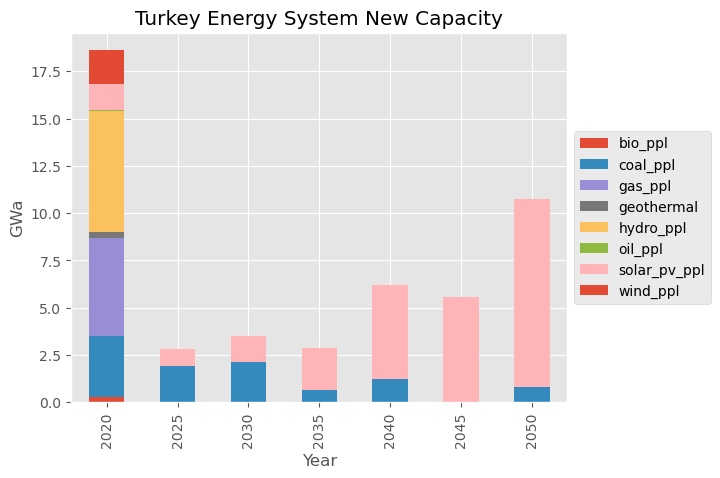

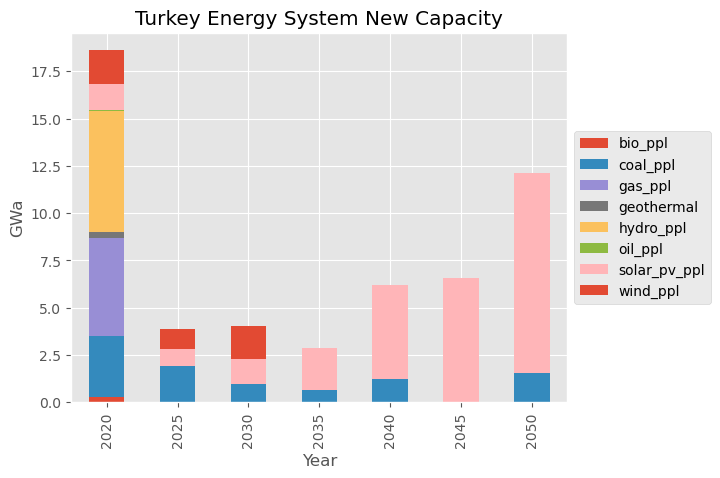

In [36]:
base_rep.get("plot new capacity")
scen_rep.get("plot new capacity")

<Axes: title={'center': 'Turkey Energy System Capacity'}, xlabel='Year', ylabel='GW'>

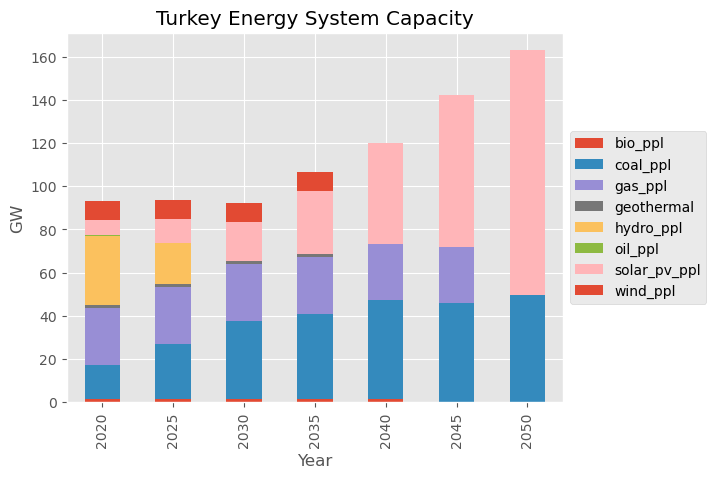

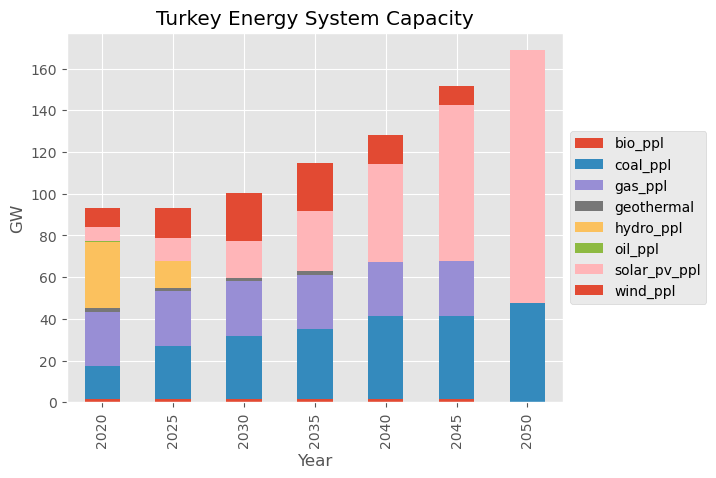

In [37]:
base_rep.get("plot capacity")
scen_rep.get("plot capacity")

<Axes: title={'center': 'Turkey Energy System Activity'}, xlabel='Year', ylabel='GWa'>

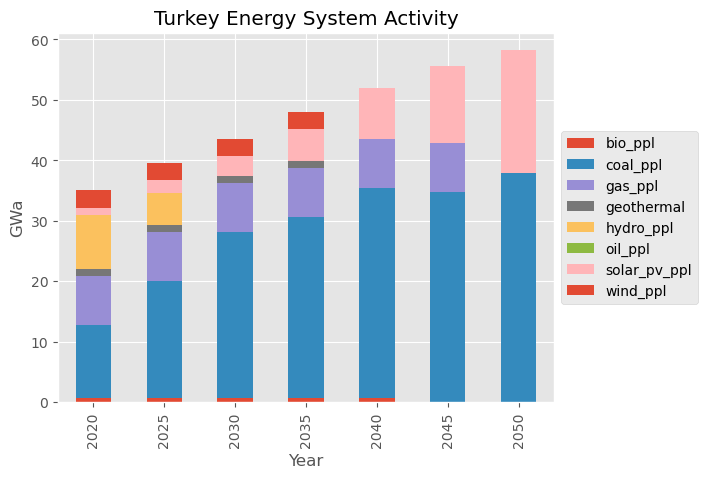

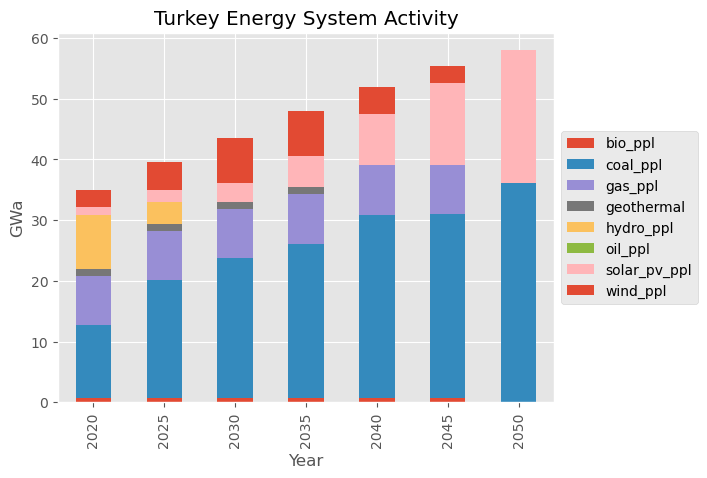

In [38]:
base_rep.get("plot activity")
scen_rep.get("plot activity")

In [39]:
mp.close_db()

In [42]:
scenario.remove_solution()
scenario.check_out()